In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
%matplotlib inline

## Building the World
Nikil Pancha
#### Creating objects
First, we create objects to view in the camera. In this case, we choose 27 points in a grid centered at zero, and then assign different colours to each

In [20]:
points = np.mgrid[-0.5:1:0.5, -0.5:1:0.5, -0.5:1:0.5].reshape(3, -1).T
colors = plt.cm.viridis(np.arange(len(points))/len(points))

#### Showing objects
Below is the pattern of objects, visualized from an arbitrary angle. 

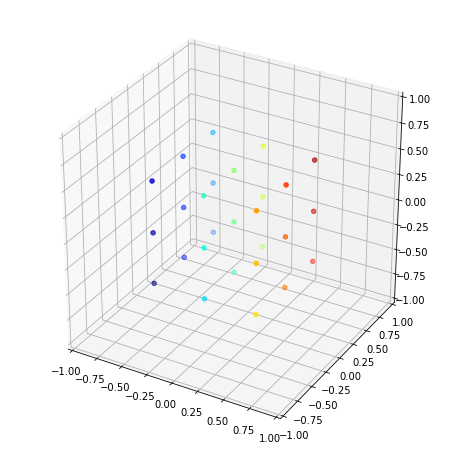

In [21]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
ax.scatter(*points.T, c=colors)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1);
# fig.show();

#### Setting up cameras
For each camera, we must specify its position and direction (i.e. the rotation and position), as well as its intrinsic properties such as focal length, film width, and film height. These two main components correspond to what is used to construct the extrinsic and intrinsic matrices respectively.

In [4]:
cam1 = {
    'position': np.array([3, -3, 2]),
    'target': np.array([0, 0, 0]),
    'up': np.array([0, 0, 1]),
    'focal_length': 0.0600,
    'film_width': 0.0350,
    'film_height': 0.0350,
    'width': 256,
    'height': 256,
}

cam2 = {
    'position': np.array([2, 3, 3]),
    'target': np.array([0, 0, 0]),
    'up': np.array([0, 0, 1]),
    'focal_length': 0.0600,
    'film_width': 0.0350,
    'film_height': 0.0350,
    'width': 256,
    'height': 256,
}

In [5]:
def get_elev_azim(cam):
    pos = np.array(cam['position'])
    azim = np.arctan2(pos[1], pos[0]) * 180/np.pi
    r = np.sqrt(pos[0]**2 + pos[1]**2)
    elev = (np.arctan2(pos[2], r)) * 180/np.pi
    return elev, azim
def camera_coordinate_system(cam):
    zcam = np.array(cam['target']) - np.array(cam['position']);
    xcam = np.cross(zcam, cam['up']);

    ycam = np.cross(zcam, xcam);
    zcam = zcam / np.linalg.norm(zcam);
    xcam = xcam / np.linalg.norm(xcam);
    ycam = ycam / np.linalg.norm(ycam);
    origin = cam['position'];
    return [xcam, ycam, zcam, origin]
def get_verts(cam):
    xcam, ycam, zcam, origin = camera_coordinate_system(cam);

    d = np.linalg.norm(cam['target']-cam['position']);
    x = 0.5 * cam['film_width'] * d / cam['focal_length'];
    y = 0.5 * cam['film_height'] * d / cam['focal_length'];

    P1 = origin + x * xcam + y * ycam + d * zcam;
    P2 = origin + x * xcam - y * ycam + d * zcam;
    P3 = origin - x * xcam - y * ycam + d * zcam;
    P4 = origin - x * xcam + y * ycam + d * zcam;
    return np.array([P1, P2, P3, P4])

#### Showing the virtual world
Here, we show the cameras by drawing the planes that show their field of view at the origin, as well as lines connecting back to the position of the camera. If we look at the solid that would be defined by extending these line segments to infinity (in the direction the camera is facing), we can say that any point inside that region would be visible by the camera, but anything outside would not be.

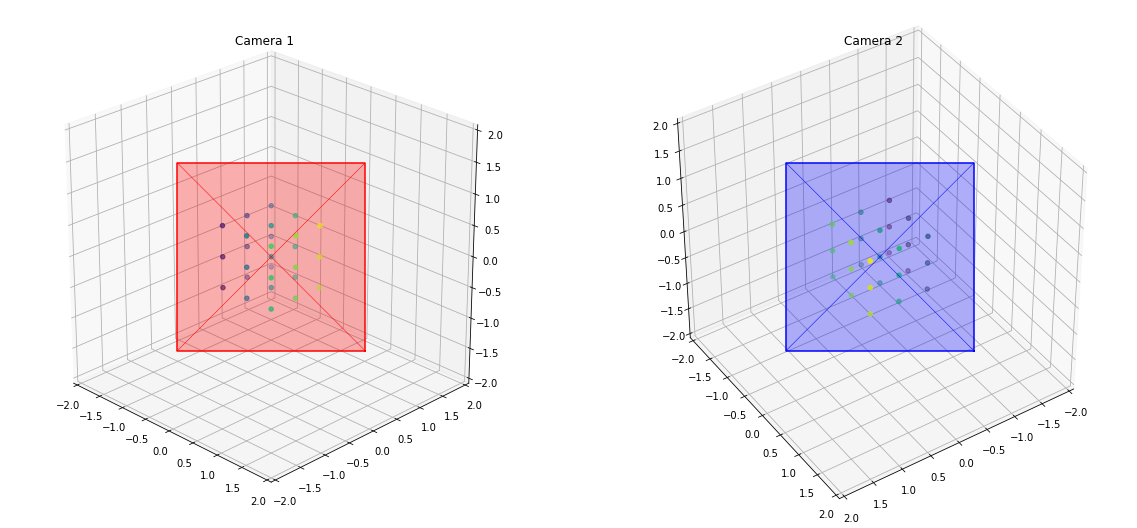

In [6]:
# cam = cam1
fig = plt.figure(figsize=(20, 10))

for r, cam in enumerate([cam1, cam2], start=1):
    ax = fig.add_subplot(1, 2, r, projection='3d')
    ax.set_aspect('equal')
    ax.scatter(*points.T, c=colors)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2);

    vs = get_verts(cam)
    pc = Poly3DCollection([vs])
    pc.set_alpha(0.3)   # Order reversed 
    if cam is cam1:
        c='r'
    else:
        c='b'
    pc.set_facecolor(c)

    for i in range(4):
        ax.plot(*zip(vs[i], cam['position']), color=c, lw=0.5)
    ax.plot([vs[i%4, 0] for i in range(5)], [vs[i%4, 1] for i in range(5)], [vs[i%4, 2] for i in range(5)], color=c)
    ax.add_collection3d(pc, zs='z')
    ax.legend(loc='best')
    ax.set_title('Camera %d'%r)
    ax.view_init(*get_elev_azim(cam))

Text(0.5,0.92,'Red is Camera 1, Blue is Camera 2')

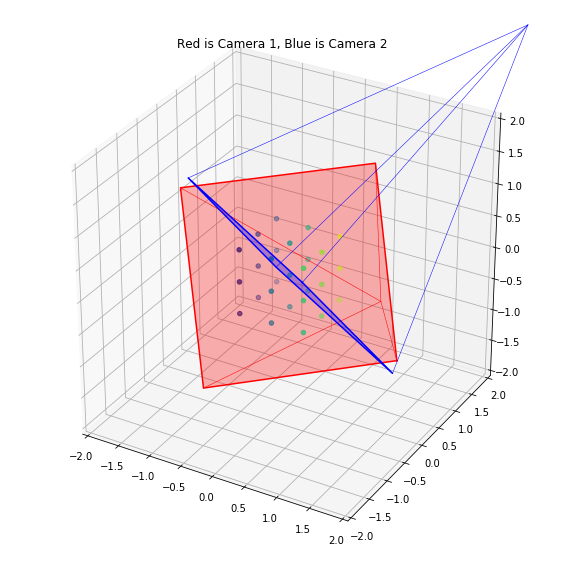

In [7]:
# cam = cam1
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
ax.scatter(*points.T, c=colors)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2);

for cam in [cam1, cam2]:
    vs = get_verts(cam)
    pc = Poly3DCollection([vs])
    pc.set_alpha(0.3)   # Order reversed 
    if cam is cam1:
        c='r'
    else:
        c='b'
    pc.set_facecolor(c)

    for i in range(4):
        ax.plot(*zip(vs[i], cam['position']), color=c, lw=0.5)
    ax.plot([vs[i%4, 0] for i in range(5)], [vs[i%4, 1] for i in range(5)], [vs[i%4, 2] for i in range(5)], color=c)
    ax.add_collection3d(pc, zs='z')
ax.legend(loc='best')
ax.set_title('Red is Camera 1, Blue is Camera 2')
# ax.view_init(30, 65)

### Camera Model
Here, we want to project points from the 3d world coordinates to a 2d image that would be what the camera would see. There are three main steps here. First, we need to translate the world coordinates of different objects into camera coordinates. This alone is a two-step process: first, we translate the coordinates so the camera is centered at the origin, and then we apply a rotation to bring the world coordinates into camera coordinates. Then, we need to determine where the image would be on the "film." Finally, we need to convert the film coordinates into pixel coordinates. These steps can be represented by 4 affine transformations, so their composition can be represented by a single matrix, which is the camera matrix.

#### Extrinsic Matrix
First, let us have a point 
$$
a = \begin{pmatrix}U \\ V \\ W \\ 1\end{pmatrix}
$$
where $(U,V,W)$ is the position in world coordinates, and the 1 is added on so that the affine transformations can be represented as matrices. If our camera is located at the point $(c_x, c_y, c_z)$ in world coordinates, then we want to first perform a transformations of $-c_x, -c_y, -c_z$ in the $x$, $y$, and $z$ coordinates respectively. This step can be represented by a matrix as follows:
$$
S = 
\begin{pmatrix}
1 & 0 & 0 & -c_x\\
0 & 1 & 0 & -c_y\\
0 & 0 & 1 & -c_z
\end{pmatrix}
$$
Next, we want to translate the axes in world coordinates to be axes in camera coordinates. We can construct the camera axes (in world coordinates) by taking cross products, so then we will get three vectors, $a_x, a_y, a_z$, which are the axes of the camera. These must be normalized, because this step is a rotation, which is a rigid transformation. If they were not unit vectors, then this would be scaling the size of objects in different directions, which is the purpose of the intrinsic matrix, not the extrinsic one.

We want a transformation $R$ such that if we apply it to $a_x$, we get $(1\;0\;0)^T$, if we apply it to $a_y$, we get $(0\;1\;0)^T$, and if we apply it to $a_z$, we get $(0\;0\;1)^T$. Because $a_x, a_y, a_z$ are all orthonormal, if let $P=(a_x\;a_y\;a_z)$, then we want $RP = I$ , so $R = I P^-1 = P^T$.

Composing the rotation and translation matrices (tranlation first), we get the extrinsic matrix.


In [8]:
def extrinsic_matrix(cam):
    xcam, ycam, zcam, origin = camera_coordinate_system(cam)
    R = np.vstack((xcam, ycam, zcam)).T
    M = np.vstack((R, -origin @ R))
    return M

#### Intrinsic Matrix
Here, we once again have two steps. First, we want to scale the image appropriately. This is based on the focal length of the lens and the width of the sensor/film. Let the focal length be $f$, the film width be $s_x$ and the film height be $s_y$. We can also say $o_x$ and $o_y$ are the offsets of the center in film coordinates from the center in pixel coordinates.

If our point is $(X\;Y\;Z)^T$ in camera coordinates, the first step is to determine what it will become in film coordinates. This can just be thought of a problem like similar triangles: if $u,v$ is the position in pixel coordinates (up to a constant offset), then we have $u=f \frac{X}{s_x Z}$ and $v=f \frac{Y}{s_y Z}$. The fraction $f/Z$ corresponds to the ratio of the distance of the object to the distance of the "film." This can be seen by observing that if we have a line in the image plane, the triangle formed by the endpoints of that line and the camera aperture should be similar to the triangle in the film coordinates (and the ratio of distances is $f/Z$). The film height and film width are only used to compensate for the fact that if we have film that is not square, the image would be distorted.

We can then come up with a matrix to project our camera coordinate point into film coordinates:
$$
    P = \begin{pmatrix}
    f & 0 & 0\\
    0 & f & 0\\
    0 & 0 & 1\\
    \end{pmatrix}
$$
This resizes the points so that only an affine transform and then division by $Z$ is required.

The final matrix is an affine transformation to scale our points to pixel coordinates, and remove warping from the sensor size.
$$
    A = \begin{pmatrix}
    1/s_x & 0 & o_y\\
    0 & 1/s_y & o_x\\
    0 & 0 & 1\\
    \end{pmatrix}
$$
Then, we can take 
$$
    \begin{pmatrix}
    u'\\
    v'\\
    z'\\
    \end{pmatrix} = A P \begin{pmatrix}
    X\\
    Y\\
    Z\\
    \end{pmatrix}
$$

Finally, we must divide by $z'$ (or equivalently $Z$), which scales the coordinates back.

In [9]:
def intrinsic_matrix(cam):
    cx = (cam['width']+1) * 0.5;
    cy = (cam['height']+1) * 0.5;

    fx = cam['focal_length'] * cam['width'] / cam['film_width'];
    fy = cam['focal_length'] * cam['height'] / cam['film_height'];
    K = np.array([[fx, 0, 0], [0, fy, 0], [cx, cy, 1]])
    return K
def camera_matrix(cam):
    return extrinsic_matrix(cam) @ intrinsic_matrix(cam)

#### Drawing an image
From the knowledge of how to construct the intrinsic and extrinsic matrices, we can compose them. We will apply the extrinsic matrix first to get points in camera coordinates, and then apply the intrinsic matrix, and scale by $z'$.

In [10]:
def world_to_xy(cam, points):
    P = camera_matrix(cam)
    points = np.hstack((points, np.ones((len(points), 1)))) @ P
    x = points[:, 0] / points[:, 2]
    y = points[:, 1] / points[:, 2]
    return np.vstack((x,y)).T
def draw_image(centers, colors, R, imshape=(256, 256)):
    im = np.ones((*imshape, 4))
    for ix, (color, center) in enumerate(zip(colors, centers)):
        for x in range(-R, R+1):
            for y in range(-R, R+1):
                if (x**2+y**2) <= R**2:
                    im[int(center[0] + x), int(center[1] + y)] = color
    return im

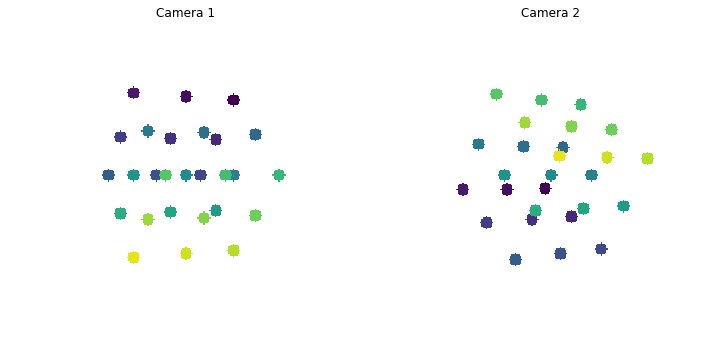

In [11]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title('Camera 1')
plt.imshow(draw_image(world_to_xy(cam1, points), colors, 5))
plt.axis('off');
plt.subplot(122)
plt.title('Camera 2')
plt.imshow(draw_image(world_to_xy(cam2, points), colors, 5))
plt.axis('off');

### Triangulation
(see separate Exercise3 for more)
Triangulation is the process of determining the location of poitns in 3d space given projections into 2d planes. With only a single image, this is impossible to determine, but if we are given examples from two camera matrices $B$, $C$, then we know that if the true position of the point is $X$, and the given points are $x=(u\;v\;1)^T$ and $y=(u'\;v'\;1)^T$, we want $k_1 x = BX$ and $k_2 x = CX$.

Let 
$$
D = \begin{pmatrix}
u B_3^T - B_1^T\\
v B_3^T - B_2^T\\
u' C_3^T - C_1^T\\
v' C_3^T - C_2^T\\
\end{pmatrix}
$$
We can then solve the system $DX = 0$ for $X$ (in the least squares sense), which corresponds to finding the minimum eigenvector of $X$.

Let us examine the first row to see how this works. We want $u B_3^T - B_1^T = 0$, or, equivalently, $u B_3^T = B_1^T$. Observe that ideally, $k_1=k_2=Z$, to undo the last step of the projection into image coordinates. This cannot be done directly, however, because we do not know $Z$. We can, however, say that in the solution, we will have that $Z = B_3^T X$ and $Z = C_3^T X$. We can see that $u B_3^T X = B_1^T X$ then becomes $uZ = B_1^T X$, which is the exact expression in the forward projection. 

In [12]:
def triangulate(points1, points2, P1, P2):
    n = len(points1)
    points3d = np.zeros((n, 3))
    for i in range(n):
        points3d[i] = triangulate_one(points1[i], points2[i], P1.T, P2.T);
    return points3d
def triangulate_one(point1, point2, P1, P2):
    A = np.zeros((4, 4))
    
    A[:2] = np.outer(point1, P1[2]) - P1[:2];
    A[2:] = np.outer(point2, P2[2]) - P2[:2];
    *_, vt = np.linalg.svd(A);
    X = vt[-1]
    X = X/X[-1]

    return X[:3]

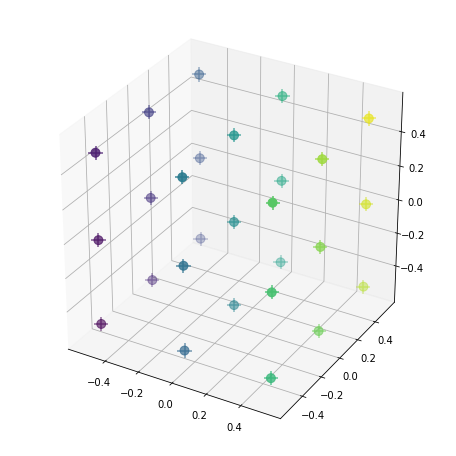

In [13]:
P1 = camera_matrix(cam1)
P2 = camera_matrix(cam2)
px1 = world_to_xy(cam1, points)
px2 = world_to_xy(cam2, points)
rec = triangulate(px1, px2, P1, P2)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
ax.scatter(*points.T, c=colors, s=80)
ax.scatter(*rec.T, c=colors, marker='+', s=200)
ax.set_xlim(-0.6, 0.6)
ax.set_ylim(-0.6, 0.6)
ax.set_zlim(-0.6, 0.6);

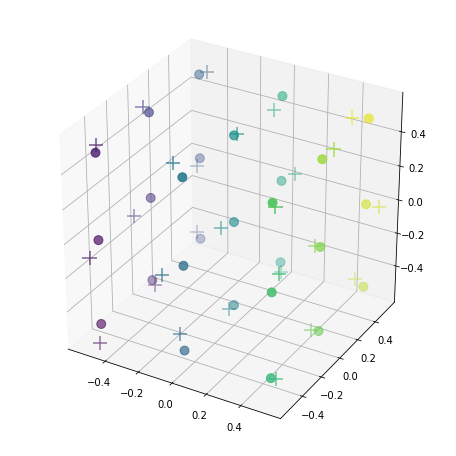

In [14]:
np.random.seed(12310192)
sigma = 5
P1 = camera_matrix(cam1)
P2 = camera_matrix(cam2)
px1 = world_to_xy(cam1, points)
px2 = world_to_xy(cam2, points)
px1 += sigma * np.random.randn(*px1.shape)
px2 += sigma * np.random.randn(*px2.shape)
rec = triangulate(px1, px2, P1, P2)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
ax.scatter(*points.T, c=colors, s=80)
ax.scatter(*rec.T, c=colors, marker='+', s=200)
ax.set_xlim(-0.6, 0.6)
ax.set_ylim(-0.6, 0.6)
ax.set_zlim(-0.6, 0.6);

#### Other triangulation methods
One other method in triangulation is to make a correction to the points before computing the triangulation. I have implemented the Sampson approximation, which uses a first order approximation to the error. This type of method works well in low-noise scenarios, but not as well when there is a lot of noise

In [15]:
def get_fundamental_matrix(p1s, p2s):
    if p1s.shape[1] != 3:
        p1s = np.append(p1s, np.ones((len(p1s),1)), axis=1)
    if p2s.shape[1] != 3:
        p2s = np.append(p2s, np.ones((len(p1s),1)), axis=1)
    W = np.array([np.outer(i,j).reshape(-1) for i,j in zip(p2s, p1s)])
    *_,vt = np.linalg.svd(W)
    F = vt[-1].reshape(3,3)
    u,s,vt = np.linalg.svd(F)
    s[2:] = 0
    return ((u*s) @ vt)
def sampson(p1, p2, F=None):
    if F is None:
        F = get_fundamental_matrix(p1, p2)
    pps = []
    for x, xp in zip(p1, p2):
        pps.append(sampson_one(x, xp, F))
    pps = np.array(pps)
    return pps[:, :2], pps[:, 2:]
def sampson_one(x, xp, F):
    bx = np.append(x, xp)
    x = np.append(x, 1)
    xp = np.append(xp, 1)
    J = np.array((F[:, 0] @ xp, F[:, 1] @ xp, F[:, 0] @ x, F[:, 1] @ x))
    update = - xp @ F @ x / (np.sum(J**2)) * J
    return bx + update

Simple triangulation: RMSE=0.18096
Sampson correction: RMSE=0.17485


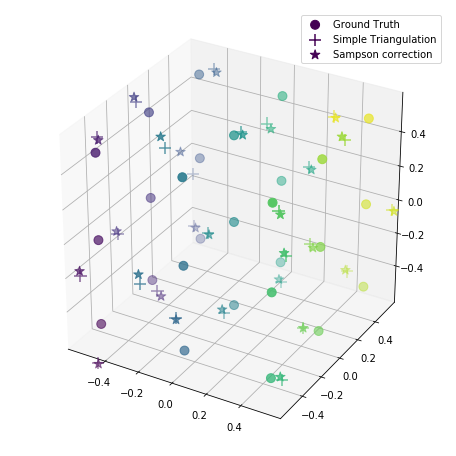

In [16]:
np.random.seed(12310192)
sigma = 10
P1 = camera_matrix(cam1)
P2 = camera_matrix(cam2)
px1 = world_to_xy(cam1, points)
px2 = world_to_xy(cam2, points)
F = get_fundamental_matrix(px1, px2)
px1 += sigma * np.random.randn(*px1.shape)
px2 += sigma * np.random.randn(*px2.shape)
# px1, px2 = sampson(px1, px2, F)
rec = triangulate(px1, px2, P1, P2)
rec2 = triangulate(*sampson(px1, px2, F), P1, P2)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
ax.scatter(*points.T, c=colors, s=80, label='Ground Truth')
ax.scatter(*rec.T, c=colors, marker='+', s=150, label='Simple Triangulation')
ax.scatter(*rec2.T, c=colors, marker='*', s=100, label='Sampson correction')
ax.legend(loc='best')
ax.set_xlim(-0.6, 0.6)
ax.set_ylim(-0.6, 0.6)
ax.set_zlim(-0.6, 0.6);
print('Simple triangulation: RMSE=%.5f'%(np.sqrt((((rec-points)**2).sum(1)).mean(0))))
print('Sampson correction: RMSE=%.5f'%(np.sqrt((((rec2-points)**2).sum(1)).mean(0))))